In [68]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

from sklearn.preprocessing import StandardScaler

from prefixspan import PrefixSpan

# Data Preparation

In [69]:
# - Attributo 'Occupancy' dato dalla media oraria dei valori di occupancy

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('dataset.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df.head()

D:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,minute,day_minute,cumulative_hour,cumulative_minute,weekend
date,,,,,,,,,,,,,,
2015-02-02 14:19:00,0,23.7000,26.272,585.200000,749.200000,0.004764,1,2,14,19,859,0,0,0
2015-02-02 14:19:59,1,23.7180,26.290,578.400000,760.400000,0.004773,1,2,14,20,860,0,1,0
2015-02-02 14:21:00,2,23.7300,26.230,572.666667,769.666667,0.004765,1,2,14,21,861,0,2,0
2015-02-02 14:22:00,3,23.7225,26.125,493.750000,774.750000,0.004744,1,2,14,22,862,0,3,0
2015-02-02 14:23:00,4,23.7540,26.200,488.600000,779.000000,0.004767,1,2,14,23,863,0,4,0


In [70]:
l = []
CO2 = []
for i, date in enumerate(list(df.index)):
    s = ''
    date = str(date)
    d = date.split(' ') #d e' la lista [data, orario]
    d1 = d[0].split('-') #d1 e' la lista [anno, mese, giorno]
    d2 = d[1].split(':') #d2 e' la lista [ore, minuti, secondi]
    anno = d1[0] #anno e' la stringa contenente l'anno
    mese = d1[1] #e' una stringa
    giorno = d1[2] #e' una stringa
    ora = d2[0] #e' una stringa
    minuto = d2[1] #e' una stringa
    secondo = d2[2] #e' una stringa
    if(giorno == '02' or giorno == '04' or giorno == '10' or giorno == '11' or giorno == '18'): # giorni non completi da saltare
        continue
    #il valore di secondo puo' essere '00' oppure '59'
    if(secondo != '00'): #devo incrementare i minuti
        secondo = '00'
        if(int(minuto) >= 9 and int(minuto) != 59):
            minuto = str(int(minuto) + 1)
        elif(int(minuto) >= 9 and int(minuto) == 59): 
            minuto = '00'
            if(int(ora) >= 9 and int(ora) != 23):
                ora = str(int(ora) + 1)
            elif(int(ora) >= 9 and int(ora) == 23):
                ora = '00'
                if(int(giorno) >= 9):
                    giorno = str(int(giorno) + 1)
                else:
                    giorno = '0' + str(int(giorno) + 1)
            else: #(int(ora) < 9):
                ora = '0' + str(int(ora) + 1)
        elif(int(minuto) < 9):
            minuto = '0' + str(int(minuto) + 1)
    s = anno + '-' + mese + '-' + giorno + ' ' + ora + ':' + minuto + ':' + secondo #s e' la stringa relativa alla data
                                                                                    #completa che inserisco nella lista l
    CO2.append(df['CO2'].iloc[i]) #mi salvo i valori di CO2
    l.append(s) #lista completa di tutte le date correttamente formattate

In [71]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  #Normalizziamo TUTTO il dataset
CO2 = scaler.fit_transform(CO2)

In [72]:
d = {'ID': [i for i in range(len(l))], 
     'date': l, 
     'CO2': CO2.ravel()}  
df = pd.DataFrame(d) #dataframe dei valori di CO2 per ogni minuto per 12 giorni [NO VALORI MANCANTI!]
df = df.set_index('ID')
df

,date,CO2
ID,,
0,2015-02-03 00:00:00,-0.769365
1,2015-02-03 00:01:00,-0.756898
2,2015-02-03 00:02:00,-0.756898
3,2015-02-03 00:03:00,-0.768811
4,2015-02-03 00:04:00,-0.771027
...,...,...
17275,2015-02-17 23:55:00,1.722332
17276,2015-02-17 23:56:00,1.705710
17277,2015-02-17 23:57:00,1.699061


In [73]:
def media_CO2(i, df): # media dei valori di CO2 nelle ultime 60 registrazioni (media oraria)
    somma = 0
    for j in range(i, i - 60 + 1, -1):
        somma += df['CO2'].iloc[j]
    return round(somma / 60, 2) #restituisce la media arrotondata a due decimali

[-0.76, -0.77, -0.79, -0.81, -0.81, -0.81, -0.81, -0.73, -0.1, 0.61, 1.41, 1.59, 1.16, 0.81, 1.22, 2.05, 2.26, 2.11, 1.38, 0.54, 0.08, -0.2, -0.34, -0.41]
[-0.75, -0.78, -0.79, -0.79, -0.78, -0.77, -0.76, -0.69, -0.0, 0.89, 1.13, 1.36, 1.3, 0.73, 0.76, 1.32, 1.25, 0.84, 0.14, -0.48, -0.66, -0.71, -0.75, -0.78]
[-0.78, -0.8, -0.81, -0.82, -0.82, -0.82, -0.82, -0.78, -0.3, 0.25, 0.51, 0.43, 0.36, -0.06, 0.24, 0.68, 0.72, 0.59, -0.01, -0.55, -0.73, -0.78, -0.79, -0.8]
[-0.8, -0.8, -0.8, -0.8, -0.79, -0.79, -0.78, -0.76, -0.75, -0.74, -0.73, -0.74, -0.76, -0.78, -0.79, -0.79, -0.8, -0.8, -0.8, -0.79, -0.79, -0.79, -0.8, -0.8]
[-0.8, -0.8, -0.8, -0.8, -0.81, -0.81, -0.82, -0.82, -0.81, -0.82, -0.82, -0.82, -0.83, -0.84, -0.85, -0.85, -0.85, -0.85, -0.84, -0.81, -0.79, -0.77, -0.76, -0.75]
[-0.73, -0.72, -0.7, -0.7, -0.7, -0.72, -0.72, -0.7, -0.67, 0.44, 1.71, 2.4, 2.29, 1.59, 2.19, 3.53, 4.22, 4.18, 2.83, 1.51, 0.63, 0.03, -0.2, -0.52]
[-0.57, -0.48, -0.43, -0.26, -0.39, -0.35, -0.24, 0.12,

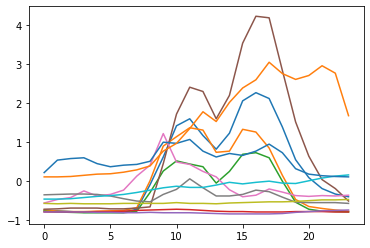

In [74]:
X = [] #X sara' una lista che conterra' 12 liste aventi ciascuna 24 valori corrispondenti alle medie orarie giornaliere
media_oraria = []

for i in range(len(df)):
    orario = df['date'].loc[i].split()[1] 
    if(orario.split(':')[1] == '59'): #sono arrivato al 59-esimo minuto... devo fare la media dei 60 valori precedenti!
        media_oraria.append(media_CO2(i, df))
    if(df['date'].loc[i].split()[1] == '23:59:00'): #se sono arrivato all'ultimo minuto della giornata appendo
                                                    #in X la lista delle medie oraria di quella giornata
        X.append(media_oraria)
        media_oraria = []
for elem in X:
    print(elem)
for elem in X:
    plt.plot(elem)
    
#STAMPO MEDIA ORARIA DELLA CO2

In [98]:
#scaler.inverse_transform(X)
# SAX transform
n_paa_segments = 24 #Dobbiamo settarli opportunamente
n_sax_symbols = 24 #Dobbiamo settarli opportunamente
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
CO2_sax = sax.fit_transform(X)

In [99]:
#['MAR_03', 'GIO_05', 'VEN_06', 'SAB_07', 'DOM_08', 'LUN_09', 'GIO_12', 'VEN_13', 'SAB_14', 'DOM_15', 'LUN_16', 'MAR_17']
CO2_sax

array([[[ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [11],
        [17],
        [22],
        [22],
        [21],
        [18],
        [21],
        [23],
        [23],
        [23],
        [21],
        [16],
        [12],
        [10],
        [ 8],
        [ 8]],

       [[ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [ 5],
        [12],
        [19],
        [20],
        [21],
        [21],
        [18],
        [18],
        [21],
        [21],
        [19],
        [13],
        [ 7],
        [ 6],
        [ 5],
        [ 5],
        [ 5]],

       [[ 5],
        [ 5],
        [ 5],
        [ 4],
        [ 4],
        [ 4],
        [ 4],
        [ 5],
        [ 9],
        [14],
        [16],
        [15],
        [15],
        [11],
        [14],
        [18],
        [18],
        [17],
        [11],
        [ 6],
        [ 5],
        [ 5],
        [ 5],
  

In [100]:
sax_CO2_inv = sax.inverse_transform(CO2_sax)
sax_CO2_inv

array([[[-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.05224518],
        [ 0.61029461],
        [ 1.53412054],
        [ 1.53412054],
        [ 1.25816156],
        [ 0.74159404],
        [ 1.25816156],
        [ 2.03683413],
        [ 2.03683413],
        [ 2.03683413],
        [ 1.25816156],
        [ 0.48877641],
        [ 0.05224518],
        [-0.15731068],
        [-0.37409541],
        [-0.37409541]],

       [[-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [-0.74159404],
        [ 0.05224518],
        [ 0.88714656],
        [ 1.05447245],
        [ 1.25816156],
        [ 1.25816156],
        [ 0.74159404],
        [ 0.74159404],
        [ 1.25816156],
        [ 1.25816156],
        [ 0.88714656],
        [ 0.15731068],
        [

[-0.88714656 -0.74159404 -0.61029461 -0.48877641 -0.37409541 -0.26414698
 -0.15731068 -0.05224518  0.05224518  0.15731068  0.26414698  0.37409541
  0.48877641  0.61029461  0.74159404  0.88714656  1.05447245  1.25816156
  1.53412054  2.03683413]


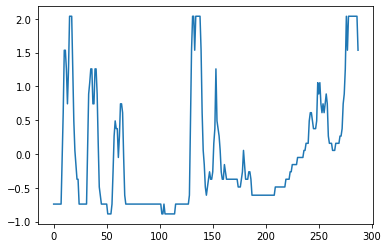

{-0.887146559018876: 'A', -0.7415940438615164: 'B', -0.6102946101863327: 'C', -0.4887764111146695: 'D', -0.3740954101977235: 'E', -0.2641469768259236: 'F', -0.1573106846101707: 'G', -0.05224518037594035: 'H', 0.05224518037594049: 'I', 0.1573106846101707: 'J', 0.2641469768259235: 'K', 0.37409541019772363: 'L', 0.4887764111146695: 'M', 0.6102946101863326: 'N', 0.7415940438615164: 'O', 0.887146559018876: 'P', 1.0544724517700528: 'Q', 1.2581615610630967: 'R', 1.5341205443525463: 'S', 2.036834131701388: 'T'}


In [101]:
print(np.unique(sax_CO2_inv))
plt.plot(sax_CO2_inv.ravel())
plt.show()

l = [chr(i) for i in range(65, 65+21)]
map_symbols = {k: v for v, k in zip(l, np.unique(sax_CO2_inv))}

print(map_symbols)

In [106]:
X_seq = list()
for x in sax_CO2_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])
    
#Togliamo gli ultimi 4 valori da ogni TS di X_seq costruendo un nuovo X_seq2

X_seq2 = []
for elem in X_seq:
    l = []
    for i, ee in enumerate(elem):
        #if(i >= 20):
         #   continue
        l.append(ee)
    X_seq2.append(l)    
    
giorni = ['MAR_03', 'GIO_05', 'VEN_06', 'SAB_07', 'DOM_08', 'LUN_09', 'GIO_12', 'VEN_13', 'SAB_14', 'DOM_15', 'LUN_16', 'MAR_17']
for g, elem in zip(giorni, X_seq2):
    print(g, elem)
    
ps = PrefixSpan(X_seq2)
print('------------------------------')
for seq in ps.topk(30, closed=True):
    print(seq)

MAR_03 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'H', 'N', 'S', 'S', 'R', 'O', 'R', 'T', 'T', 'T', 'R', 'M', 'I', 'G', 'E', 'E']
GIO_05 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'I', 'P', 'Q', 'R', 'R', 'O', 'O', 'R', 'R', 'P', 'J', 'D', 'C', 'B', 'B', 'B']
VEN_06 ['B', 'B', 'B', 'A', 'A', 'A', 'A', 'B', 'F', 'K', 'M', 'L', 'L', 'H', 'K', 'O', 'O', 'N', 'H', 'C', 'B', 'B', 'B', 'B']
SAB_07 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
DOM_08 ['B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
LUN_09 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'M', 'S', 'T', 'T', 'S', 'T', 'T', 'T', 'T', 'T', 'S', 'N', 'I', 'G', 'D']
GIO_12 ['C', 'D', 'E', 'F', 'E', 'E', 'F', 'J', 'L', 'R', 'M', 'L', 'K', 'I', 'F', 'E', 'E', 'G', 'F', 'E', 'E', 'E', 'E', 'E']
VEN_13 ['E', 'E', 'E', 'E', 'E', 'E', 'D', 'D', 'D', 'E', 'F', 'I', 'G', 'E', 'E', 'E', 'F', 'F', 'E', '

MAR_03


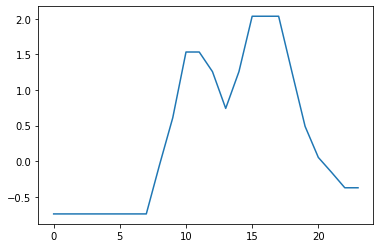

GIO_05


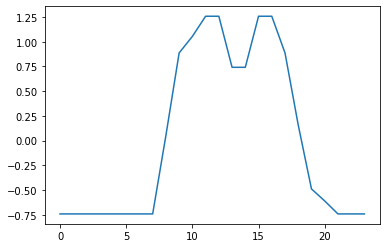

VEN_06


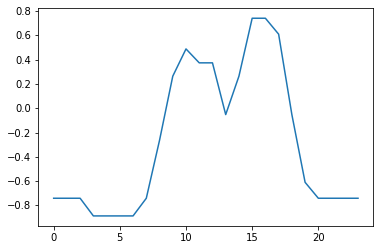

SAB_07


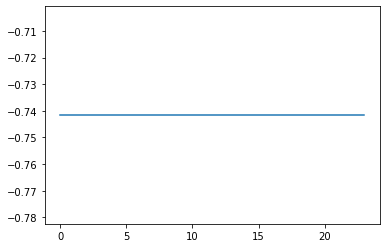

DOM_08


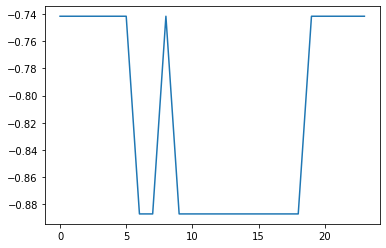

LUN_09


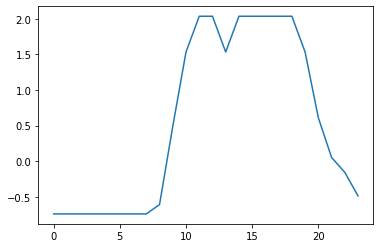

GIO_12


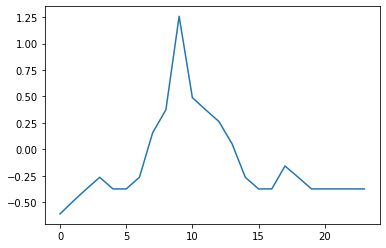

VEN_13


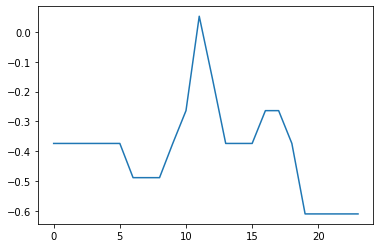

SAB_14


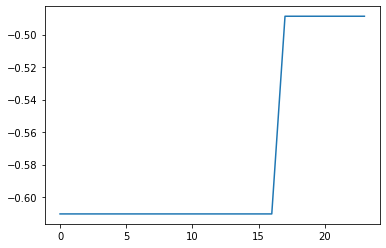

DOM_15


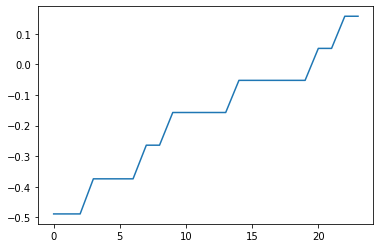

LUN_16


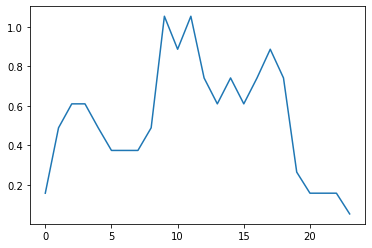

MAR_17


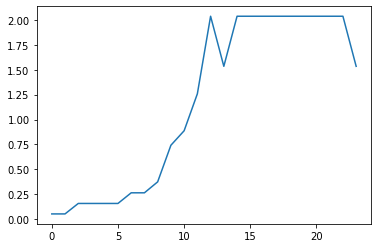

In [104]:
giorni = ['MAR_03', 'GIO_05', 'VEN_06', 'SAB_07', 'DOM_08', 'LUN_09', 'GIO_12', 'VEN_13', 'SAB_14', 'DOM_15', 'LUN_16', 'MAR_17']
for g, elem in zip(giorni, sax_CO2_inv):
    print(g)
    plt.plot(elem)
    plt.show()

In [21]:
from tslearn.utils import to_time_series_dataset, check_equal_size, ts_size

X_ = to_time_series_dataset(X)

mean = np.nanmean(X_, axis=1)[:, np.newaxis, :]

std = np.nanstd(X_, axis=1)[:, np.newaxis, :]

tmp = sax_X_inv * std + mean

Inv_X = []
l = []
for i, elem in enumerate(tmp.ravel()):
    if(i % 24 == 0 and i != 0):
        Inv_X.append(l)
        l = []
    l.append(round(elem, 2))
Inv_X.append(l)
Inv_X[0][0] = round(Inv_X[0][0], 2)

Inv_X_NO_SERA = []
for elem in Inv_X:
    l = []
    for i, ee in enumerate(elem):
        #if(i >= 20):
         #   continue
        l.append(ee)
    Inv_X_NO_SERA.append(l) 

giorni = ['MAR_03', 'GIO_05', 'VEN_06', 'SAB_07', 'DOM_08', 'LUN_09', 'GIO_12', 'VEN_13', 'SAB_14', 'DOM_15', 'LUN_16', 'MAR_17']
for g, elem in zip(giorni, Inv_X_NO_SERA):
    print(g, elem)
    print()
    
#NOTA: I primi 3 valori di MAR_03  che erano delle B, e i primi valori di GIO_05 anch'essi delle B, corrispondono
#in realta' a valori diversi!!

MAR_03 [421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62]

GIO_05 [421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 467.34, 467.34, 421.62, 421.62, 421.62, 421.62, 421.62]

VEN_06 [421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 467.34, 467.34]

SAB_07 [467.34, 421.62, 421.62, 421.62, 467.34, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 467.34, 421.62, 421.62, 421.62]

DOM_08 [421.62, 421.62, 421.62, 467.34, 421.62, 467.34, 467.34, 421.62, 421.62, 421.62, 421.62, 421.62, 421.62, 467.34, 467.34, 421.62, 421.62, 467.34, 421.62, 421.62, 421.62, 421.62, 421.62, 421.

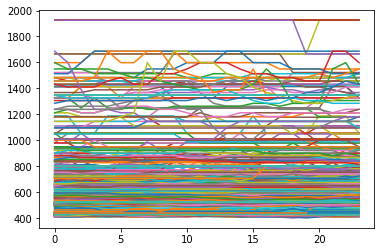

In [22]:
for elem in Inv_X:
    plt.plot(elem)
    plt.show

In [23]:
ps = PrefixSpan(X_seq2)
for sequence in ps.topk(5, closed=True):
    print(sequence)

(12, ['E', 'E', 'E', 'E', 'F', 'F', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K',

In [25]:
ps = PrefixSpan(Inv_X)
for sequence in ps.topk(5, closed=True):
    print(sequence)

(36, [431.43])
(34, [436.14])
(32, [527.0, 527.0])
(31, [422.2])
(31, [431.43, 431.43])


# ADESSO FACCIAMO 12 TS DA 1440 MINUTI 
# (qua ho ancora lasciato le lettere)

In [26]:
# - Attributo 'Occupancy' dato dalla media oraria dei valori di occupancy

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('dataset.csv', parse_dates=True, index_col='date', date_parser=dateparse)

l = []
for date in list(df.index):
    s = ''
    date = str(date)
    d = date.split(' ')
    d1 = d[0].split('-')
    d2 = d[1].split(':')
    anno = d1[0]
    mese = d1[1]
    giorno = d1[2]
    ora = d2[0]
    minuto = d2[1]
    secondo = d2[2]
    #print(type(giorno))
    if(giorno == '02' or giorno == '04' or giorno == '10' or giorno == '11' or giorno == '18'):
        continue
    if(secondo != '00'): 
        secondo = '00'
        if(int(minuto) >= 9 and int(minuto) != 59):
            minuto = str(int(minuto) + 1)
        elif(int(minuto) >= 9 and int(minuto) == 59): 
            minuto = '00'
            if(int(ora) >= 9 and int(ora) != 23):
                ora = str(int(ora) + 1)
            elif(int(ora) >= 9 and int(ora) == 23):
                ora = '00'
                if(int(giorno) >= 9):
                    giorno = str(int(giorno) + 1)
                else:
                    giorno = '0' + str(int(giorno) + 1)
            else: #(int(ora) < 9):
                ora = '0' + str(int(ora) + 1)
        elif(int(minuto) < 9):
            minuto = '0' + str(int(minuto) + 1)
    s = anno + '-' + mese + '-' + giorno + ' ' + ora + ':' + minuto + ':' + secondo
    l.append(s)
#for date in l:
#    print(date)

d = {'ID': [i for i in range(len(l))], 'date': l, 'CO2': [df['CO2'].iloc[i] for i in range(20560 - len(l), 20560)]}
df = pd.DataFrame(d)
df = df.set_index('ID')

def media_CO2(i, df):
    somma = 0
    for j in range(i, i - 60 + 1, -1):
        somma += df['CO2'].iloc[j]
    return round(somma / 60, 2)

X = []
l = []

for i in range(len(df)):
    l.append(df['CO2'].loc[i])
    if(df['date'].loc[i].split()[1] == '23:59:00'):
        X.append(l)
        l = []
#for elem in X:
#    print(elem)


In [13]:
#X = np.array(X)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X = scaler.fit_transform(X)
#scaler.inverse_transform(X)
# SAX transform
n_paa_segments = 1000 #Dobbiamo settarli opportunamente
n_sax_symbols = 21 #Dobbiamo settarli opportunamente
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
X_sax = sax.fit_transform(X)
sax_X_inv = sax.inverse_transform(X_sax)

print(np.unique(sax_X_inv))
plt.plot(sax_X_inv.ravel())
plt.show()

l = [chr(i) for i in range(65, 65+21)]
map_symbols = {k: v for v, k in zip(l, np.unique(sax_X_inv))}

print(map_symbols)

X_seq = list()
for x in sax_X_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])
    
#Togliamo gli ultimi 4 valori da ogni TS di X_seq costruendo un nuovo X_seq2
"""
X_seq2 = []
for elem in X_seq:
    l = []
    for i, ee in enumerate(elem):
        if(i >= 20):
            continue
        l.append(ee)
    X_seq2.append(l)    
"""
giorni = ['MAR_03', 'GIO_05', 'VEN_06', 'SAB_07', 'DOM_08', 'LUN_09', 'GIO_12', 'VEN_13', 'SAB_14', 'DOM_15', 'LUN_16', 'MAR_17']
for g, elem in zip(giorni, X_seq):
    print(g, elem)
    
ps = PrefixSpan(X_seq)
ps.topk(20, closed=True)

[-1.9807524  -1.46523379 -1.17976112 -0.96742157 -0.79163861 -0.63748416
 -0.49720057 -0.36610636 -0.24104039 -0.11964811  0.          0.11964811
  0.24104039  0.36610636  0.49720057  0.63748416  0.79163861  0.96742157
  1.17976112  1.46523379  1.9807524 ]


KeyboardInterrupt: 

In [ ]:
for item in ps.topk(5, closed=True):
    print(item)

In [ ]:
for item in ps.frequent(10, closed=True):
    print(item)